In [19]:
import numpy as np
from PIL import Image as pim
import os
import matplotlib.pyplot as plt
import csv

def calculate_profiles(image_array):
    profile_x = np.sum(image_array == 0, axis=0)
    profile_y = np.sum(image_array == 0, axis=1)
    return profile_x, profile_y 

def calculate_black_mass(image_array):
    height, width = image_array.shape
    half_height, half_width = height // 2, width // 2

    quarters = [
        image_array[:half_height, :half_width],
        image_array[:half_height, half_width:],
        image_array[half_height:, :half_width],
        image_array[half_height:, half_width:]
    ]

    black_masses = [np.sum(quarter == 0) for quarter in quarters]
    return black_masses

def calculate_normalized_black_mass(image_array):
    height, width = image_array.shape
    quarter_area = (height // 2) * (width // 2)
    
    black_masses = calculate_black_mass(image_array)
    normalized_black_masses = [mass / quarter_area for mass in black_masses]
    
    return normalized_black_masses

def calculate_center_of_gravity(image_array):
    black_pixels = np.argwhere(image_array == 0)
    if len(black_pixels) == 0:
        return (0, 0)
    
    center_of_gravity = np.mean(black_pixels, axis=0)
    return tuple(center_of_gravity)

def calculate_normalized_center_of_gravity(image_array, center_of_gravity):
    height, width = image_array.shape
    normalized_center_of_gravity = (
        center_of_gravity[0] / height,
        center_of_gravity[1] / width
    )
    return normalized_center_of_gravity

def calculate_moments_of_inertia(image_array, center_of_gravity):
    height, width = image_array.shape
    y_center, x_center = center_of_gravity

    y_indices, x_indices = np.indices((height, width))
    y_indices = y_indices - y_center
    x_indices = x_indices - x_center

    horizontal_moment = np.sum((image_array == 0) * (x_indices ** 2))
    vertical_moment = np.sum((image_array == 0) * (y_indices ** 2))

    return horizontal_moment, vertical_moment

def calculate_normalized_moments_of_inertia(image_array, moments_of_inertia):
    height, width = image_array.shape
    area = height * width

    normalized_horizontal_moment = moments_of_inertia[0] / area
    normalized_vertical_moment = moments_of_inertia[1] / area

    return normalized_horizontal_moment, normalized_vertical_moment

def calculate_features(image_array):
    normalized_black_masses = calculate_normalized_black_mass(image_array)
    center_of_gravity = calculate_center_of_gravity(image_array)
    normalized_center_of_gravity = calculate_normalized_center_of_gravity(image_array, center_of_gravity)
    moments_of_inertia = calculate_moments_of_inertia(image_array, center_of_gravity)
    normalized_moments_of_inertia = calculate_normalized_moments_of_inertia(image_array, moments_of_inertia)

    features = normalized_black_masses + list(normalized_center_of_gravity) + list(normalized_moments_of_inertia)
    return features

def euclidean_distance(features1, features2):
    return np.sqrt(np.sum((np.array(features1) - np.array(features2)) ** 2))

def similarity_measure(features1, features2):
    distance = euclidean_distance(features1, features2)
    return 1 / (1 + distance)

def crop_image(image):
    binary_image = image.point(lambda x: 255 if x > 128 else 0, '1')
    pixels = binary_image.load()
    width, height = binary_image.size
    min_x, min_y = width, height
    max_x, max_y = 0, 0

    for x in range(width):
        for y in range(height):
            if pixels[x, y] == 0:
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
    if min_x < max_x and min_y < max_y:
        image = image.crop((min_x, min_y, max_x + 1, max_y + 1))
    return image 

def resize_image(image, size=(32, 32)):
    return image.resize(size, pim.Resampling.LANCZOS)

def process_alphabet(folder_path, size=(32, 32)):
    alphabet_features = {}
    plt.figure(figsize=(15, 15))
    image_index = 1
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            image = pim.open(file_path).convert('L')
            image = crop_image(image)
            image = resize_image(image, size)
            image_array = np.array(image)
            if image_array.size > 0:

                plt.subplot(8, 8, image_index)
                plt.imshow(image_array, cmap='gray')
                plt.title(filename)
                plt.axis('off')
                image_index += 1

                features = calculate_features(image_array)
                alphabet_features[filename] = features
    plt.tight_layout()
    plt.show()
    return alphabet_features

def calculate_similarities(image_array, alphabet_features, size=(32, 32)):
    plt.figure(figsize=(15, 15))
    image_indexCS = 1
    cropped_image = crop_image(pim.fromarray(image_array))
    resized_image = resize_image(cropped_image, size)
    features = calculate_features(np.array(resized_image))
    similarities = []
    for char, char_features in alphabet_features.items():
        similarity = similarity_measure(features, char_features)
        if np.array(cropped_image).size > 0:
            similarities.append((char, similarity))
    plt.subplot(8, 8, image_indexCS)
    plt.imshow(resized_image, cmap='gray')
    plt.axis('off')
    image_indexCS += 1
    plt.tight_layout()
    plt.show()
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities



chars = "هونملگکقفغعظطضصشسژزرذدخحچجثتپبا" 

image1 = pim.open('../../symbols/ب.png').convert('L')
image2 = pim.open('../../symbols/ث.png').convert('L')

image1_array = np.array(image1)
image2_array = np.array(image2)

features1 = calculate_features(image1_array)
features2 = calculate_features(image2_array)

similarity = similarity_measure(features1, features2)
print("Similarity:", similarity)


Similarity: 0.010787992269543743


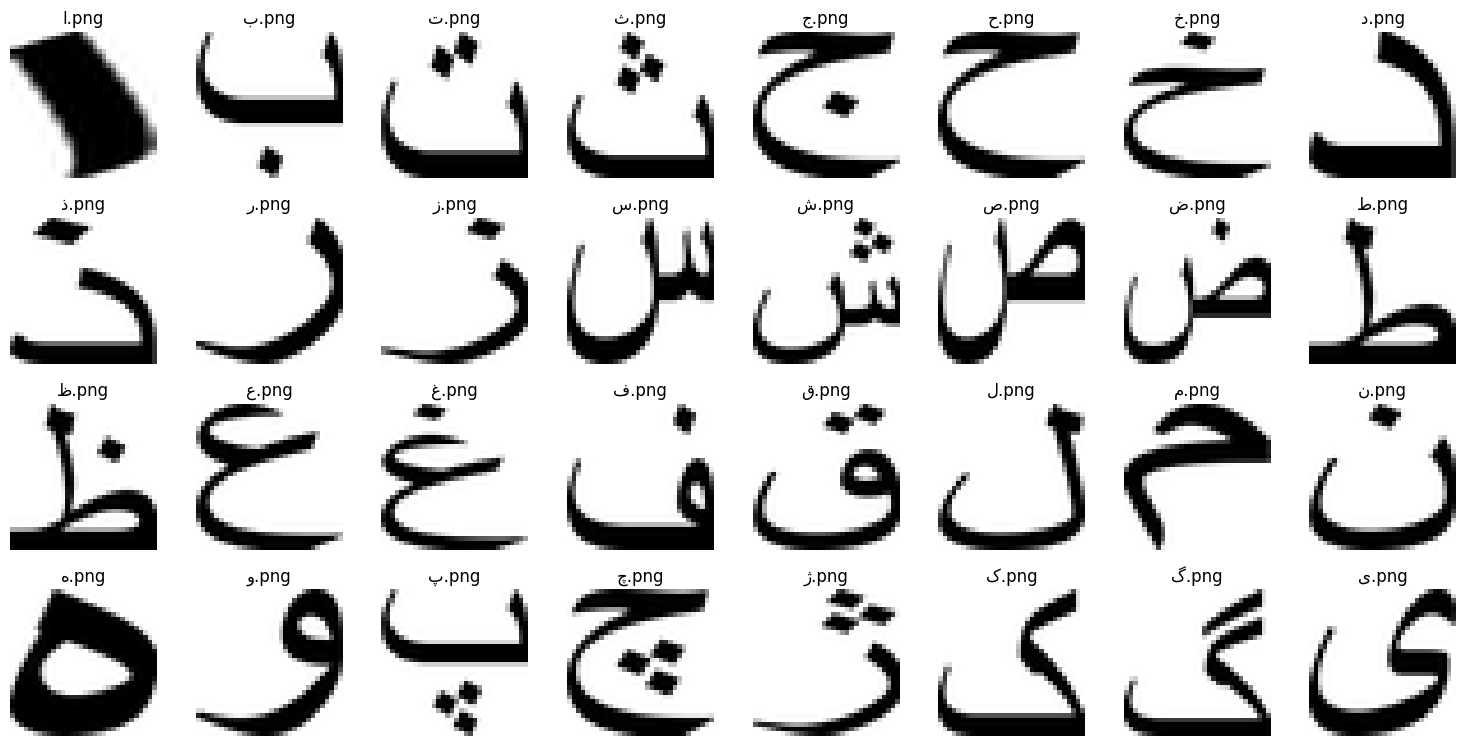

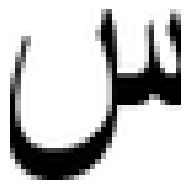

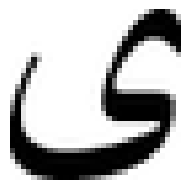

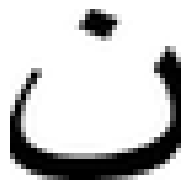

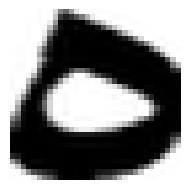

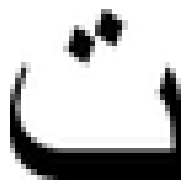

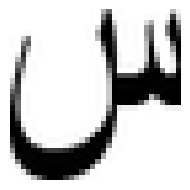

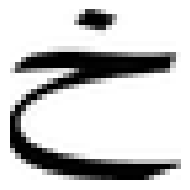

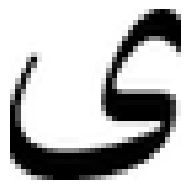

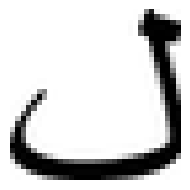

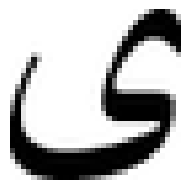

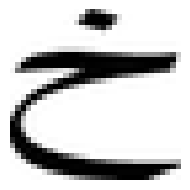

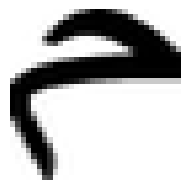

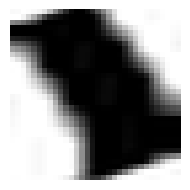

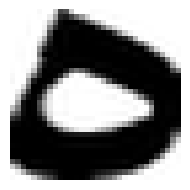

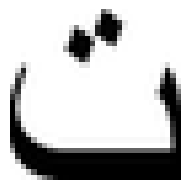

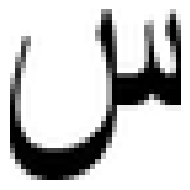

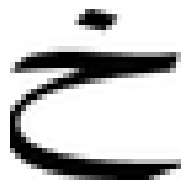

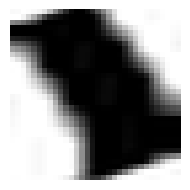

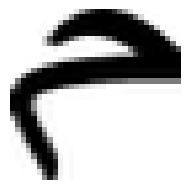

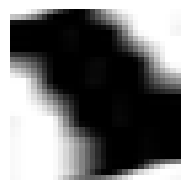

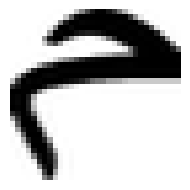

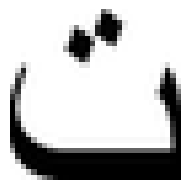

In [20]:
def save_similarities_to_file(similarities, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        for idx, symbol_similarities in enumerate(similarities):
            row = [f"{idx + 1}:"] + [f"({char}, {sim:.2f})" for char, sim in symbol_similarities]
            writer.writerow(row)

def segment_lines(image_array):
    profile_y = np.sum(image_array == 0, axis=1)
    segments = []

    in_segment = False
    start = 0

    for i, value in enumerate(profile_y):
        if value > 0 and not in_segment:
            in_segment = True
            start = i
        elif value == 0 and in_segment:
            in_segment = False
            end = i
            segments.append((start, end))

    if in_segment:
        segments.append((start, len(profile_y)))

    return segments

def segment_characters(image_array):
    profile_x, _ = calculate_profiles(image_array)
    segments = []

    in_segment = False
    start = 0

    for i, value in enumerate(profile_x):
        if value > 0 and not in_segment:
            in_segment = True
            start = i
        elif value == 0 and in_segment:
            in_segment = False
            end = i
            segments.append((start, end))

    if in_segment:
        segments.append((start, len(profile_x)))

    return segments

alphabet_folder = '../../symbols'
alphabet_features = process_alphabet(alphabet_folder, size=(32, 32))

input_image = pim.open('input/string.bmp').convert('L')
input_image_array = np.array(input_image)
line_segments = segment_lines(input_image_array)
symbol_similarities = []
for line_start, line_end in line_segments:
    line_image = input_image_array[line_start:line_end, :]
    char_segments = segment_characters(line_image)

    for char_start, char_end in char_segments:
        char_image = line_image[:, char_start:char_end]
        similarities = calculate_similarities(char_image, alphabet_features, size=(32, 32))
        symbol_similarities.append(similarities)

output_file = 'output/similarities.csv'
save_similarities_to_file(symbol_similarities, output_file)


In [24]:
def extract_best_hypotheses(symbol_similarities):
    best_hypotheses = []
    for similarities in symbol_similarities:
        best_hypothesis = max(similarities, key=lambda x: x[1])[0]
        best_hypothesis = best_hypothesis.replace('.png', ' ')  
        best_hypotheses.append(best_hypothesis)
    return best_hypotheses

def calculate_accuracy(recognized_string, original_string):
    correct_count = sum(1 for r, o in zip(recognized_string, original_string) if r == o)
    accuracy = correct_count / len(original_string)
    return accuracy


original_string = 'خ ی ل ی خ س ت ه ن ی س ت م ا م ا خ س ت ه ا م'  


best_hypotheses = extract_best_hypotheses(symbol_similarities)
recognized_string = ''.join(best_hypotheses)


accuracy = calculate_accuracy(recognized_string, original_string)
print("Recognized string:", recognized_string)
print("Accuracy:", accuracy)


Recognized string: م ی س ه ت س خ ی ق ی گ م ا ه ط ن ک ا م د ف ط 
Accuracy: 0.5581395348837209


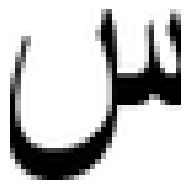

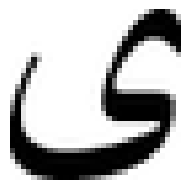

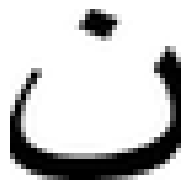

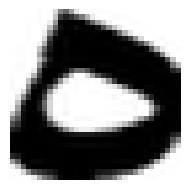

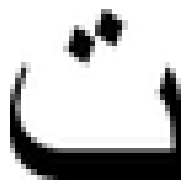

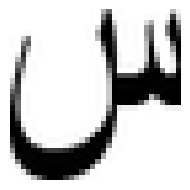

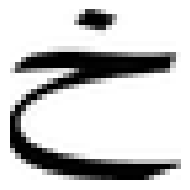

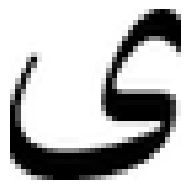

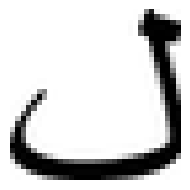

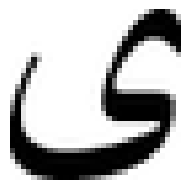

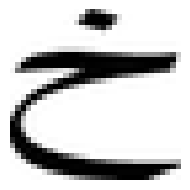

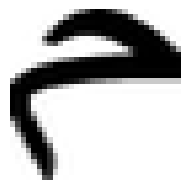

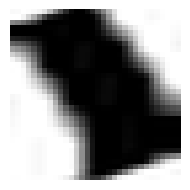

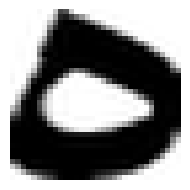

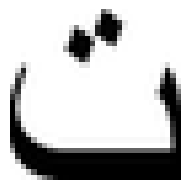

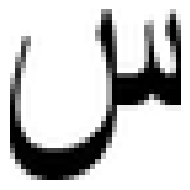

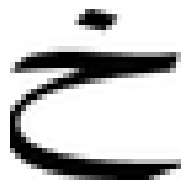

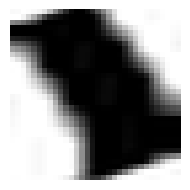

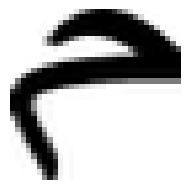

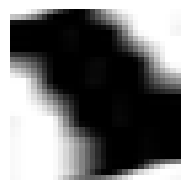

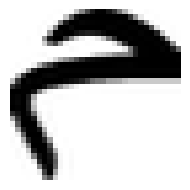

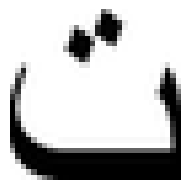

New recognized string: م ی س ه ت س خ ی ق ی گ م ا ه ط ن ک ا م د ف ط 
New accuracy: 0.5581395348837209


In [26]:
from PIL import ImageFont, ImageDraw


new_input_image = pim.open("input/string2.bmp").convert('L')
new_input_image_array = np.array(new_input_image)

new_segments = segment_characters(new_input_image_array)
new_symbol_similarities = []
for line_start, line_end in line_segments:
    line_image = input_image_array[line_start:line_end, :]
    char_segments = segment_characters(line_image)

    for char_start, char_end in char_segments:
        char_image = line_image[:, char_start:char_end]
        similarities = calculate_similarities(char_image, alphabet_features, size=(32, 32))
        new_symbol_similarities.append(similarities)

new_best_hypotheses = extract_best_hypotheses(new_symbol_similarities)
new_recognized_string = ''.join(new_best_hypotheses)

new_accuracy = calculate_accuracy(new_recognized_string, original_string)
print("New recognized string:", new_recognized_string)
print("New accuracy:", new_accuracy)
